In [324]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import scipy.optimize as opt
import multiprocessing as mp

In [1]:
### ALPHA SIGNALS FROM THE NEW ROOM (sam's) ###

In [263]:
file = "DataR_CH1@DT5730_1463_150um_roomtest_alphas.lh5" # path to raw file
dsp_file_ex = "DataR_CH1@DT5730_1463_150um_roomtest_alphas_dsp.lh5" # path to output dsp file but we dont need this here
out_start = "newroom_alpha_outs/trap_"
out_start_wfs = "newroom_alpha_outs/wfs_"

In [260]:
dsp_config = {
    "outputs": ["bl", "trapEftp"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [261]:
dsp_config2 = {
    "outputs": ["bl", "trapEftp", "wf_pz", "wf_blsub", "wf_etrap"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [270]:
def process_data(rise, flat, config=dsp_config):
    dsp_db = {
        "CompassEvent": {
            "pz_tau": "0.6*ms",
            "etrap": {
                "rise": f"{rise}*us",
                "flat": f"{flat}*us"
            },
            "ftp": 1000 + (rise + 0.5*flat)/(0.002)
        }
    }
  
    build_dsp(
        f_raw=file, 
        f_dsp=out_start + f"rise_{rise:.2f}_flat_{flat:.2f}.lh5",
        lh5_tables = f"CompassEvent",
        dsp_config = config,
        database = dsp_db,
        write_mode = 'r'
    )

def make_iterable(rises, flats):
    iterable = []
    for rise in rises:
        for flat in flats:
            iterable.append((rise,flat))
    return iterable

In [278]:
rises_chunk = np.linspace(0.1, 5, 50) # Change this
flats_chunk = np.linspace(0.1, 1, 10)
cores = 6

iterable = make_iterable(rises_chunk, flats_chunk)
#print(iterable)
chunk = int(round(len(rises_chunk)*len(flats_chunk)/cores))

'''
with mp.Pool(processes=cores) as p:
    p.starmap(process_data, iterable, chunksize=chunk)
            
'''

'\nwith mp.Pool(processes=cores) as p:\n    p.starmap(process_data, iterable, chunksize=chunk)\n            \n'

In [291]:
####### NECESSARY GLOBAL VARIABLES ########
bins = np.linspace(0, 700, 1401)          #
binwidth = bins[1] - bins[0]              #
bin_centers = bins[:-1] + binwidth/2      #
print(binwidth)                           #
print(bins)                               #
print(bin_centers)                        #
###########################################

0.5
[0.000e+00 5.000e-01 1.000e+00 ... 6.990e+02 6.995e+02 7.000e+02]
[2.5000e-01 7.5000e-01 1.2500e+00 ... 6.9875e+02 6.9925e+02 6.9975e+02]


In [394]:
def select_n_cut(dsp_file, range = False):
    f = h5py.File(dsp_file)
    trapEftp = f['CompassEvent']['trapEftp']
    if range:
        noise_cut = trapEftp[range[0]:range[1]]
    else:
        noise_cut = trapEftp[:]

    noise_cut = noise_cut[noise_cut > 400]
    return noise_cut


def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Define the fit function 
def fit_func(x, mu, sigma, eta, tau1, tau2):
    return 0.5 * (((1-eta)/tau1 * np.exp((x-mu)/tau1 + 0.5*(sigma/tau1)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau1)))
                  + (eta/tau2 * np.exp((x-mu)/tau2 + 0.5*(sigma/tau2)**2) * sp.erfc(1/np.sqrt(2)*((x-mu)/sigma + sigma/tau2))))


# Define the cdf of the fit function
def cdf_fit_func(x, A, mu, sigma, eta, tau1, tau2):
    return A * np.cumsum(fit_func(x, mu, sigma, eta, tau1, tau2)) * binwidth


# Iminuit optimizer function takes actual data and returns the optimized fit and params 
def optimizer(counts, gimme_moar=False):
    c = cost.ExtendedBinnedNLL(counts, bins, cdf_fit_func)
    m = Minuit(c, A=10000, mu=600, sigma=5, eta=0.25, tau1=20, tau2=20)
    m.limits["A"] = (2000, 14000)
    m.limits["sigma"] = (0.5,35)
    m.limits["tau1"] = (0.05, 1000)
    m.limits["tau2"] = (0.05, 1000)
    m.limits['eta'] = (0,1)
    var = m.migrad()  # need to call migrad but prob dont need the return variable
    A_fit = m.values['A']
    mean_fit = m.values['mu']
    std_fit = m.values['sigma']
    eta_fit = m.values['eta']
    tau1_fit = m.values['tau1']
    tau2_fit = m.values['tau2']
    fwhm_fit = 2.355*std_fit
    energy_fwhm = fwhm_fit*3271.2/mean_fit
    energy_resolution = fwhm_fit/mean_fit

    minuit_fit = A_fit * fit_func(bins, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit)
    if gimme_moar:
        return minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution
    else:
        return minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution


# Plotting function which plots the fit and the data along with some other info
def plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, g_fit_package = False, rise = False, flat = False):
    #plt.plot(x, test_fit, color='green', label='Test Fit', alpha = 0.75)
    plt.hist(noise_cut, bins=bins, color='blue', alpha=0.5)
    plt.plot(bins, minuit_fit, color='red', label='Minuit Fit', alpha = 0.75)
    if g_fit_package:
        plt.plot(bin_centers, g_fit_package[0], color='black', label='Half-Gaussian Fit')
        plt.text(0.02, 0.55, 'Half-Gaussian Fit Energy_Resolution:' + str(round(g_fit_package[1]*100, 2)) + '%', transform=plt.gca().transAxes)
        plt.text(0.02, 0.6, 'Half-Gaussian Fit Energy_FWHM:' + str(round(g_fit_package[2], 2)) + ' keV', transform=plt.gca().transAxes)
    plt.axvline(mean_fit, color='black', linestyle='--', label='Minuit Mean: ' + str(round(mean_fit, 2)))
    plt.axvline(mean_fit + fwhm_fit/2, color='black', linestyle=':', label='Minuit FWHM: ' + str(round(fwhm_fit, 2)))
    plt.axvline(mean_fit - fwhm_fit/2, color='black', linestyle=':')
    plt.text(0.02, 0.65, 'Minuit Energy Resolution: ' + str(round(energy_resolution*100, 2)) + '%', transform=plt.gca().transAxes)
    plt.text(0.02, 0.7, 'Minuit Energy FWHM: ' + str(round(energy_fwhm, 2)) + ' keV', transform=plt.gca().transAxes)
    plt.xlim(550, 607)

    if rise and flat:
        plt.title(f'Gd-148 Alpha Spectrum [Rise: {rise:.2f}us, Flat: {flat:.2f}us]')
    else:
        plt.title('Gd-148 Alpha Spectrum')
    plt.xlabel('Energy (ADC)')
    plt.ylabel('Counts')
    #plt.ylim(1e-2, 2e2)
    #plt.yscale('log')
    plt.legend()
    #plt.ylim(1e-1, 2e3)
    #plt.yscale('log')
    plt.show()

def plot_heat_map(e_fwhm_array, rises, flats):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(e_fwhm_array, origin='lower')
    round_rises = np.around(rises, 2)
    round_flats = np.around(flats, 2)
    axs.set_xticks(np.arange(len(flats)), labels=round_flats)
    axs.set_yticks(np.arange(len(rises)), labels=round_rises)
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title("Energy Resolution vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()


6.0 0.010075566750629723


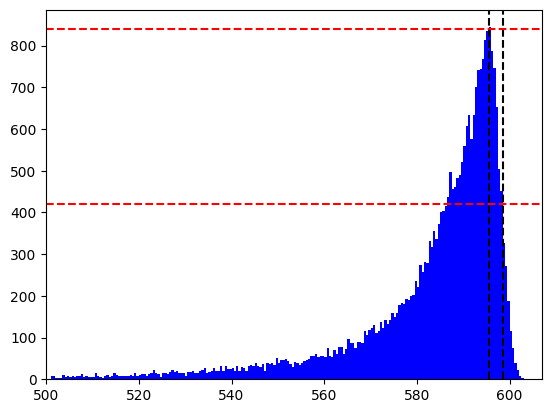

In [277]:
dat = select_n_cut(dsp_file_ex)
meany = 595.5
upper = 598.5
plt.hist(dat, bins=bins, color='blue')
plt.axvline(meany, color='black', linestyle='--')
plt.axvline(upper, color='black', linestyle='--')
plt.axhline(420, color='red', linestyle='--')
plt.axhline(840, color='red', linestyle='--')
plt.xlim(500, 607)
fwhm_eye = (upper-meany) * 2
e_res_eye = fwhm_eye/meany
print(fwhm_eye, e_res_eye)

27379 28095 11782 11137
6.0 0.010075566750629723


(450.0, 610.0)

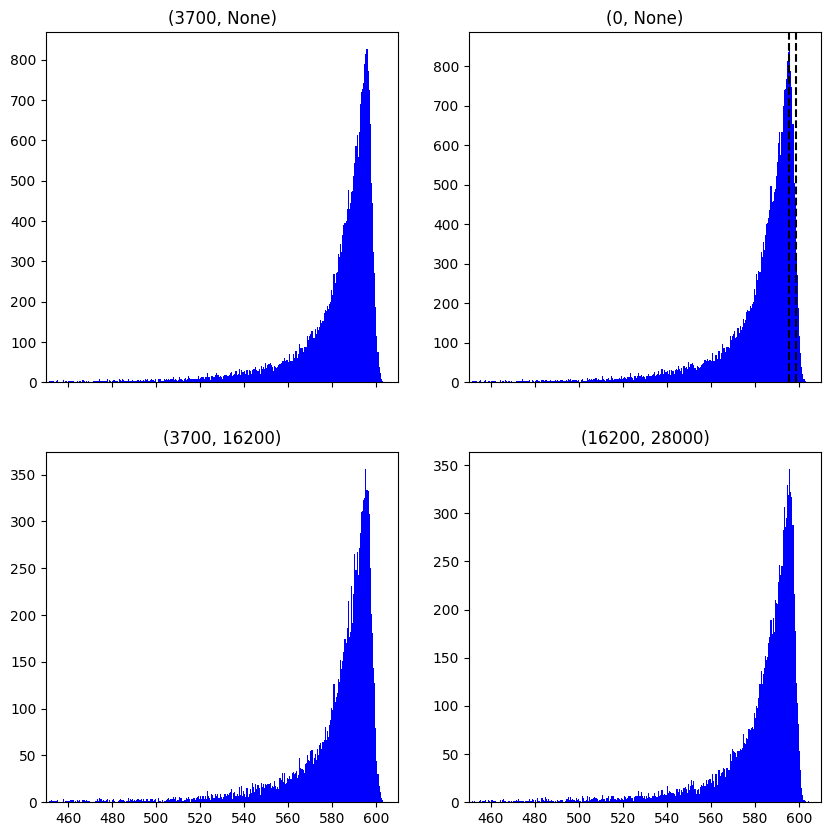

In [273]:
# # # hist test cell # # #

bins_temp = np.linspace(0, 700, 1401)
range1 = (3700, None)
range2 = (0, None)
range3 = (3700, 16200)
range4 = (16200, 28000)

noisey_cut1 = select_n_cut(dsp_file_ex, range = range1)
noisey_cut2 = select_n_cut(dsp_file_ex, range = range2)
noisey_cut3 = select_n_cut(dsp_file_ex, range = range3)
noisey_cut4 = select_n_cut(dsp_file_ex, range = range4)

print(len(noisey_cut1), len(noisey_cut2), len(noisey_cut3), len(noisey_cut4))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,10))
ax0.hist(noisey_cut1, bins=bins_temp, color='blue')
ax0.set_title(range1)
ax1.hist(noisey_cut2, bins=bins_temp, color='blue')
ax1.set_title(range2)


ax2.hist(noisey_cut3, bins=bins_temp, color='blue')
ax2.set_title(range3)
ax3.hist(noisey_cut4, bins=bins_temp, color='blue')
ax3.set_title(range4)
#plt.axhline(840, color='black', linestyle='--')
#plt.axvline(595.5, color='black', linestyle='--')
#plt.axhline(420, color='black', linestyle='--')
#plt.axvline(598.5, color='black', linestyle='--')
#fwhm_eye = (598.5-595.5) * 2
#e_res_eye = fwhm_eye/595.5
#print(fwhm_eye, e_res_eye)

plt.xlim(450, 610)
#plt.xlim(550,610)
#plt.xlim(400,450)
#plt.ylim(0,10)
#counts, _ = np.histogram(noise_cut, bins=bins)
#minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(counts, gimme_moar=True)
#plot_fit(noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, rise=rise_ex, flat=flat_ex)

In [368]:
def fit_half_gauss(data, gimme_all=False):
    counts, _ = np.histogram(data, bins=bins)
    max_counts = np.max(counts)
    max_index = np.argmax(counts)
    walk_left = max_index - 3
    left_val = counts[walk_left]
    cut_counts = counts[walk_left:]
    cut_data = data[data > left_val]
    x = bin_centers[walk_left:]
    popt, pcov = opt.curve_fit(gaussian, x, cut_counts, p0=[max_counts, bin_centers[max_index], 5])
    mean_temp = popt[1]
    stdev_temp = popt[2]
    e_res_temp = stdev_temp*2.355/mean_temp
    if gimme_all:
        return popt, cut_data, cut_counts, x, counts, max_index, walk_left, max_counts
    else:
        return e_res_temp, popt
    


[456.6659971  613.42727521   8.48050759]
[837.7465652  597.00256264   2.52465158]
[861.78650588 594.31441996   2.51662596]


"\ncounts1, _, _= ax1.hist(data1, bins=bins, color='red')\nfill1 = np.ones(len(counts1))\nmax1 = np.max(counts1)\nhalf_max1 = max1/2.0\n\n\nfor i, count in enumerate(counts1):\n    if count < half_max1:\n        counts1[i] = 0\n\n\n\nax2.bar(bin_centers, counts1, width=binwidth, color='blue', alpha = 0.5)\n\n\ndata1_cut = data1[data1 > half_max1]\nax3.hist(data1_cut, bins=bins, color='blue')\n"

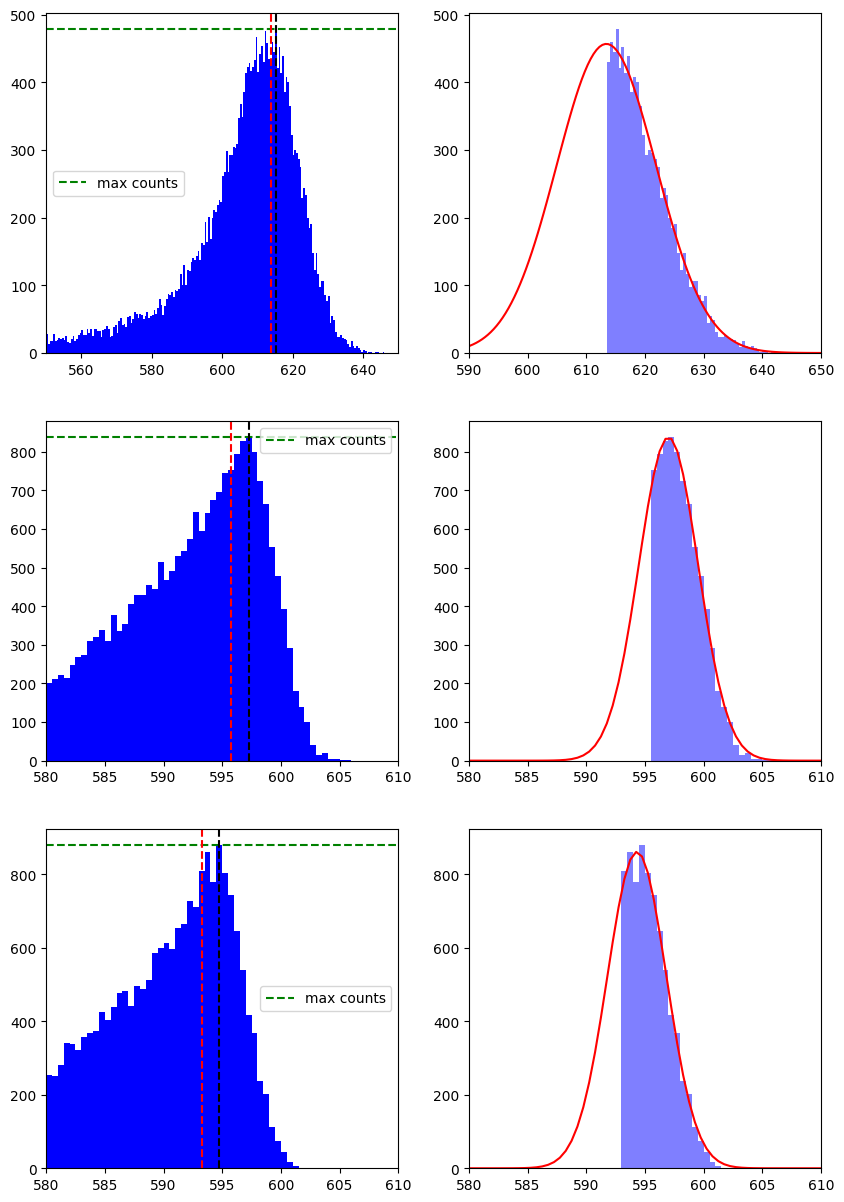

In [366]:
#### Testing grounds for fit half gauss ####

input1 = out_start + "rise_0.10_flat_0.10.lh5"
input2 = out_start + "rise_2.50_flat_0.10.lh5"
input3 = out_start + "rise_5.00_flat_0.10.lh5"

data1 = select_n_cut(input1)
data2 = select_n_cut(input2)
data3 = select_n_cut(input3)
datas = [data1, data2, data3]

mean1 = np.mean(data1)
mean2 = np.mean(data2)
mean3 = np.mean(data3)

std1 = np.std(data1)
std2 = np.std(data2)
std3 = np.std(data3)


fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(10,15))
xlims = [[(550, 650),(590, 650)], 
         [(580, 610),(580, 610)], 
         [(580, 610),(580, 610)]]
for i, data in enumerate(datas):
    popt1, cut_data1, cut_counts1, x1, counts1, max_index1, walk_left1, max_counts1 = fit_half_gauss(data, gimme_all=True)
    print(popt1)
    a1 = popt1[0]
    mu1 = popt1[1]
    sigma1 = popt1[2]
    axes[i][0].hist(data, bins=bins, color='blue')
    axes[i][0].axhline(max_counts1, color='green', linestyle='--', label='max counts')
    axes[i][0].axvline(bin_centers[max_index1], color='black', linestyle='--')
    axes[i][0].axvline(bin_centers[walk_left1], color='red', linestyle='--')
    axes[i][0].set_xlim(xlims[i][0])
    axes[i][0].legend()

    axes[i][1].bar(x1, cut_counts1, width=binwidth, color='blue', alpha = 0.5)
    g_fit = gaussian(bin_centers, a1, mu1, sigma1)
    axes[i][1].plot(bin_centers, g_fit, color='red', label='Gaussian Fit')
    axes[i][1].set_xlim(xlims[i][1])

#ax2.bar(range(len(subset1)), subset1, color='blue', alpha=0.5)

'''
counts1, _, _= ax1.hist(data1, bins=bins, color='red')
fill1 = np.ones(len(counts1))
max1 = np.max(counts1)
half_max1 = max1/2.0


for i, count in enumerate(counts1):
    if count < half_max1:
        counts1[i] = 0



ax2.bar(bin_centers, counts1, width=binwidth, color='blue', alpha = 0.5)


data1_cut = data1[data1 > half_max1]
ax3.hist(data1_cut, bins=bins, color='blue')
'''

#plt.legend()
#plt.xlim(450, 650)


Rise: 0.1us, Flat: 0.1us
Mean: 613.4272752082223, FWHM: 19.971595375197605, Energy Resolution: 0.032557397074361304
Rise: 0.1us, Flat: 0.2us
Mean: 607.0592372889438, FWHM: 21.231428498519897, Energy Resolution: 0.034974228533836325
Rise: 0.1us, Flat: 0.30000000000000004us
Mean: 604.6701733001119, FWHM: 19.76746737519175, Energy Resolution: 0.03269132205960603
Rise: 0.1us, Flat: 0.4us
Mean: 601.5163014358089, FWHM: 20.502679933731383, Energy Resolution: 0.034084994678933625
Rise: 0.1us, Flat: 0.5us
Mean: 599.8561935231606, FWHM: 20.256102592021936, Energy Resolution: 0.033768264478609304
Rise: 0.1us, Flat: 0.6us
Mean: 599.369863317097, FWHM: 18.924564501078038, Energy Resolution: 0.03157410083373842
Rise: 0.1us, Flat: 0.7000000000000001us
Mean: 597.2278579616874, FWHM: 20.438538040062877, Energy Resolution: 0.03422234540401165
Rise: 0.1us, Flat: 0.8us
Mean: 596.7643493184198, FWHM: 19.867634899023614, Energy Resolution: 0.03329226171388247
Rise: 0.1us, Flat: 0.9us
Mean: 595.593809393937

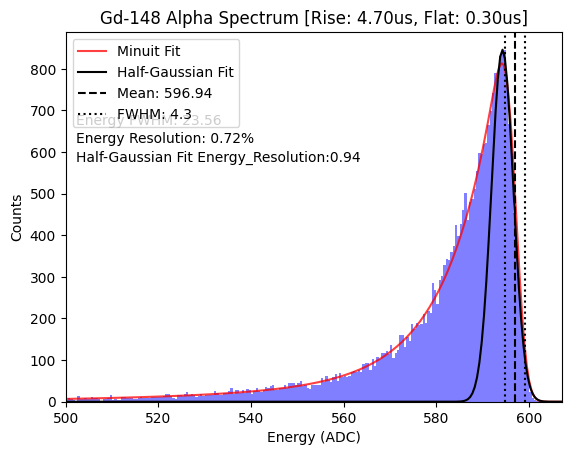

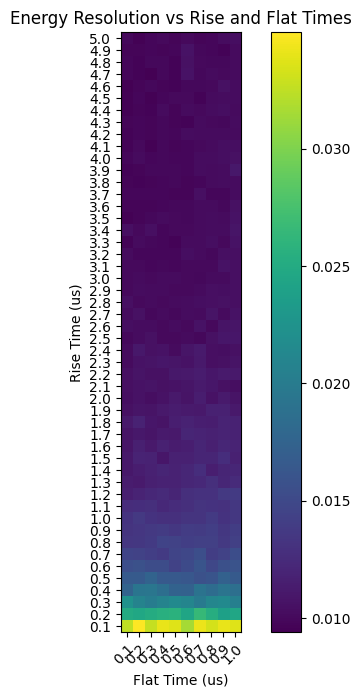

In [383]:
rises_choice = np.linspace(0.1, 5, 50) # Change this
flats_choice = np.linspace(0.1, 1, 10)

fits = [[None]*len(flats_choice) for _ in range(len(rises_choice))]
e_res_array = np.zeros((len(rises_choice), len(flats_choice)))
#print(np.shape(e_fwhm_array))

#fig, ax = plt.subplots(len(rises), len(flats), figsize=(10,10))

for i, rise in enumerate(rises_choice):
    for j, flat in enumerate(flats_choice):
        input_dsp_file = out_start + f"rise_{rise:.2f}_flat_{flat:.2f}.lh5"
        noise_cut = select_n_cut(input_dsp_file)
        counts, _ = np.histogram(noise_cut, bins=bins)  #need
        e_res, params= fit_half_gauss(noise_cut)
        e_res_array[i][j] = e_res
        fits[i][j] = params
        #plot_data(ax[i,j], noise_cut, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution)
        print(f'Rise: {rise}us, Flat: {flat}us')
        print(f'Mean: {params[1]}, FWHM: {2.355*params[2]}, Energy Resolution: {e_res}')

#print(e_fwhm_array)


46 2
Rise: 4.7us, Flat: 0.30000000000000004us


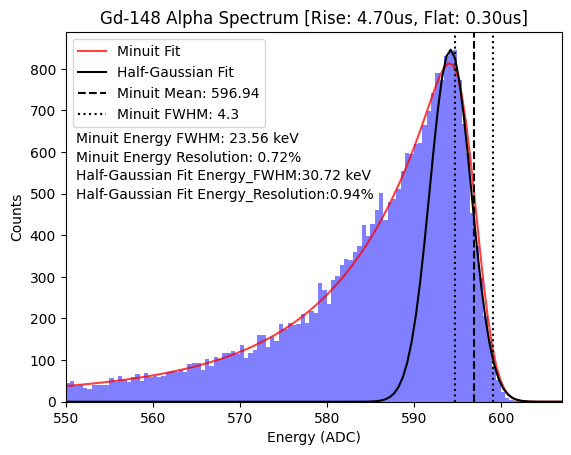

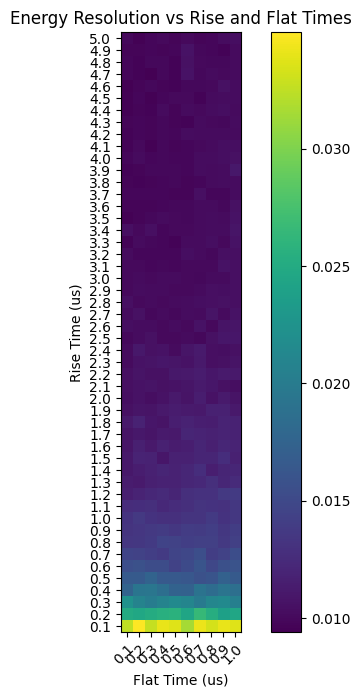

In [396]:
# Find the index of the minimum element
min_index = np.argmin(e_res_array)
row, col = np.unravel_index(min_index, e_res_array.shape)  # Convert the flattened index to row and column indices
best_rise = rises_choice[row]
best_flat = flats_choice[col]
print(row,col)
print(f'Rise: {best_rise}us, Flat: {best_flat}us')
best_data = select_n_cut(out_start + f"rise_{best_rise:.2f}_flat_{best_flat:.2f}.lh5")
best_counts, _ = np.histogram(best_data, bins=bins)  #need
minuit_fit, c, A_fit, mean_fit, std_fit, eta_fit, tau1_fit, tau2_fit, fwhm_fit, energy_fwhm, energy_resolution = optimizer(best_counts, gimme_moar=True)
e_res_gauss, params = fit_half_gauss(best_data)
gaussian_fit = gaussian(bin_centers, params[0], params[1], params[2])
g_efwhm = e_res_gauss*3271.2
g_fit_package = [gaussian_fit, e_res_gauss, g_efwhm]
plot_fit(best_data, minuit_fit, mean_fit, fwhm_fit, energy_fwhm, energy_resolution, g_fit_package=g_fit_package, rise = best_rise, flat = best_flat)

plot_heat_map(e_res_array, rises_choice, flats_choice)

In [398]:
dsp_db_fin = {
        "CompassEvent": {
            "pz_tau": "0.6*ms",
            "etrap": {
                "rise": f"{best_rise}*us",
                "flat": f"{best_flat}*us"
            },
            "ftp": 1000 + (best_rise + 0.5*best_flat)/(0.002)
        }
    }
  
build_dsp(
    f_raw=file, 
    f_dsp=out_start_wfs + f"rise_{best_rise:.2f}_flat_{best_flat:.2f}.lh5",
    lh5_tables = f"CompassEvent",
    dsp_config = dsp_config2,
    database = dsp_db_fin,
    write_mode = 'r'
)

Processing table CompassEvent:  10%|9         | 3200/32729 [00:09<01:25, 343.43 rows/s]

In [399]:
f = h5py.File(out_start_wfs + f"rise_{best_rise:.2f}_flat_{best_flat:.2f}.lh5")
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

5.0


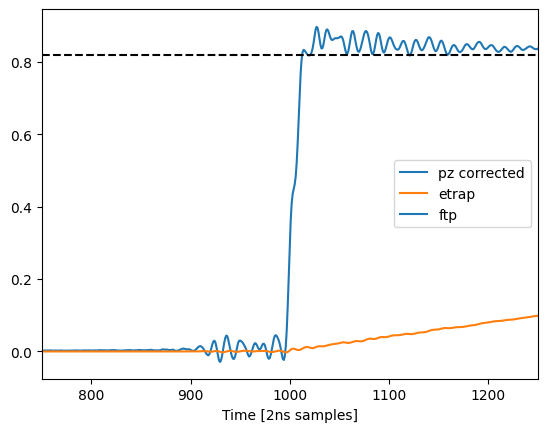

In [403]:
#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline((1000 + (best_rise + 0.5*best_flat)/(0.002)), label="ftp");
plt.axhline(0.82, color='black', linestyle='--')
plt.xlabel("Time [2ns samples]")
plt.legend()
#plt.xlim(1000, 8000)
plt.xlim(750,1250)
print(rise)

(0.0, 50.0)

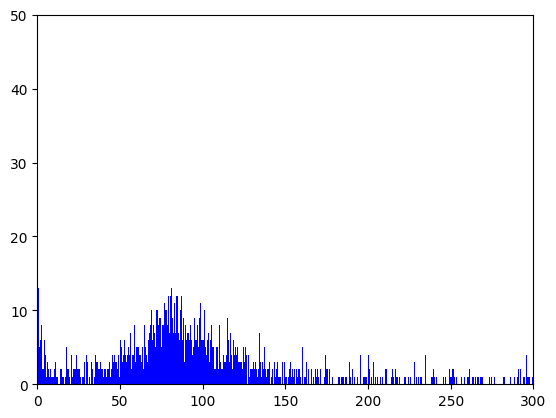

In [416]:
### Looking for Muons ###
muon_file = out_start_wfs + f"rise_{best_rise:.2f}_flat_{best_flat:.2f}.lh5"
f_muon = h5py.File(muon_file)
trapEftp = f_muon['CompassEvent']['trapEftp']
data_muon = trapEftp[3700:]
low_data = data_muon[data_muon < 300]
#low_data = 
plt.hist(low_data, bins=bins, color='blue')
plt.xlim(0, 300)
plt.ylim(0,50)

(0.0, 2000.0)

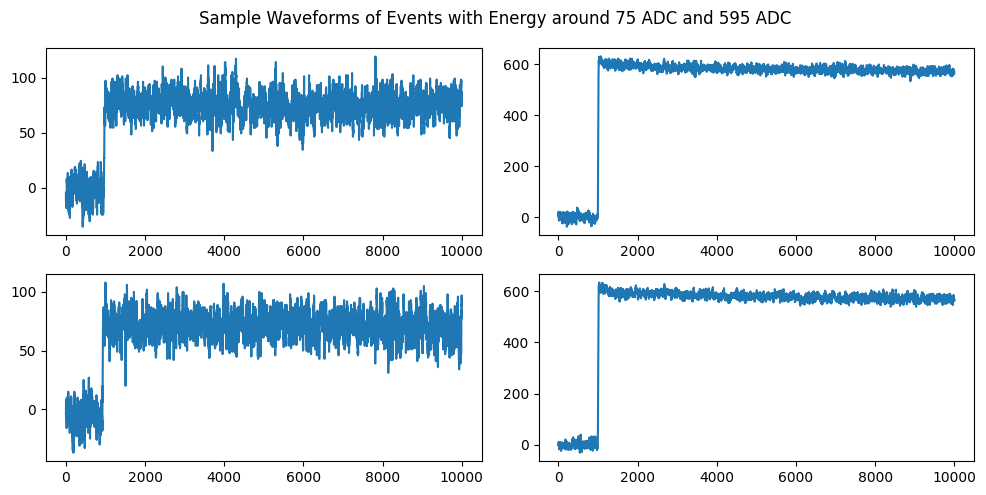

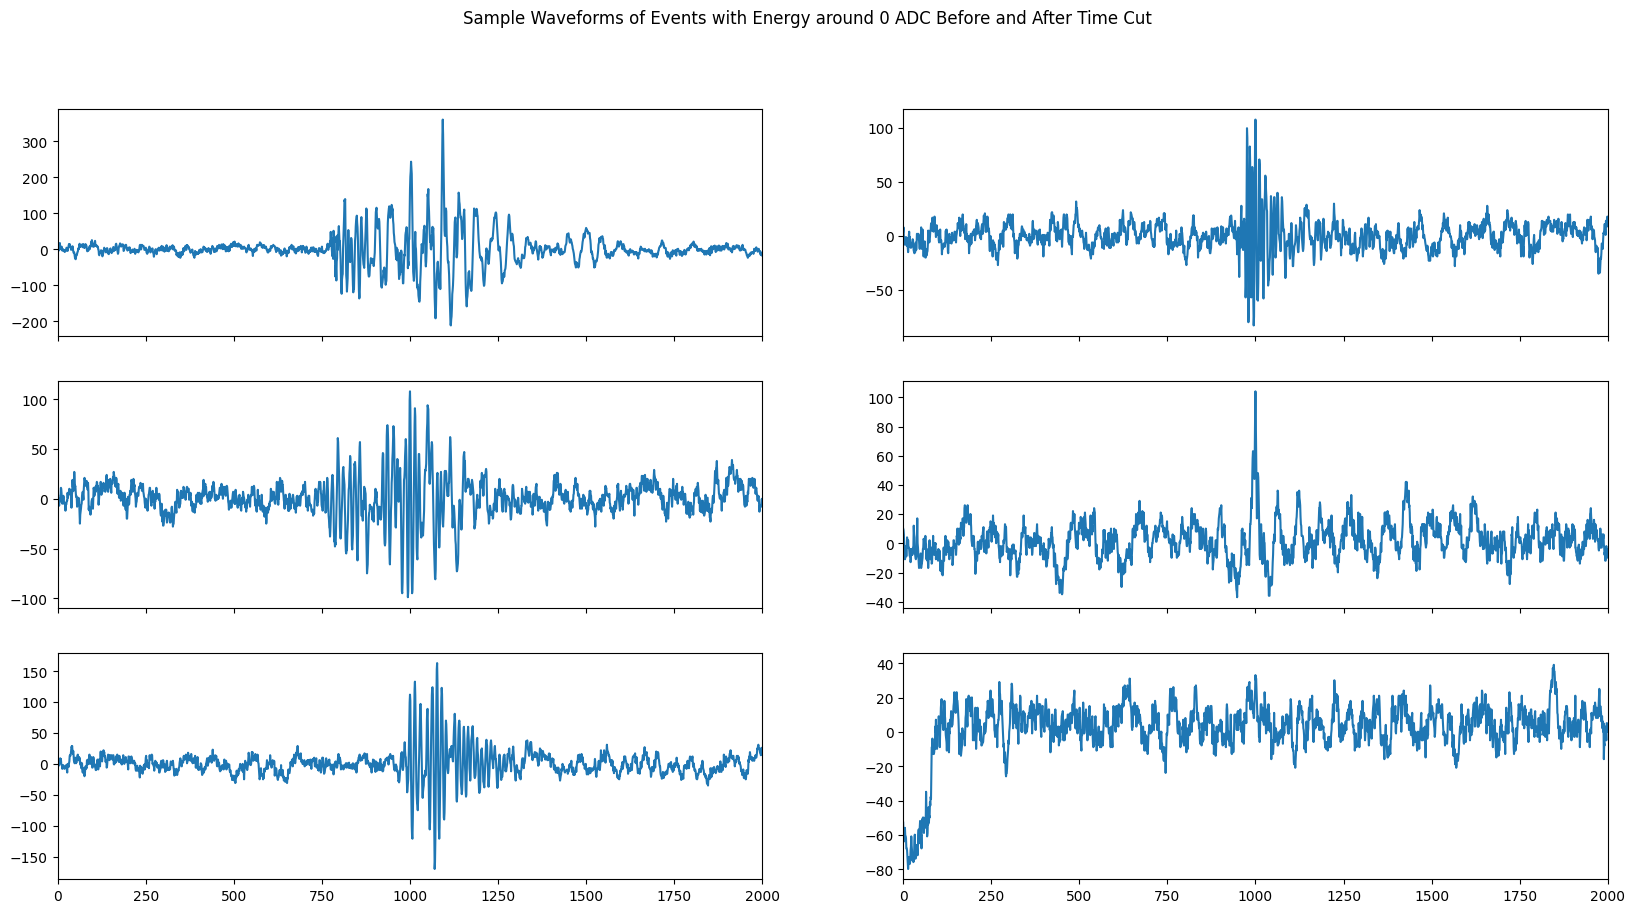

In [435]:
### Looking for Muons ###
muon_file = out_start_wfs + f"rise_{best_rise:.2f}_flat_{best_flat:.2f}.lh5"
f_muon = h5py.File(muon_file, 'r')
trapEftp = f_muon['CompassEvent']['trapEftp'][:]
waveforms = f_muon['CompassEvent']['wf_blsub']['values'][:]

# Filter events with energies around 75 ADC (e.g., between 70 and 80 ADC)
energy_around_75 = trapEftp[(trapEftp >= 70) & (trapEftp <= 80)]
energy_at_595 = trapEftp[(trapEftp >= 595) & (trapEftp <= 595.1)]
energy_around_0 = trapEftp[(trapEftp >= 0) & (trapEftp <= 10)]
time_cut = trapEftp[3700:]
wf_time_cut = waveforms[3700:]
energy_around_0_time_cut = time_cut[(time_cut >= 0) & (time_cut <= 10)]

# Get indices of these events
indices = np.where((trapEftp >= 70) & (trapEftp <= 80))[0]
indices_595 = np.where((trapEftp >= 595) & (trapEftp <= 595.1))[0]
indices_0 = np.where((trapEftp >= 0) & (trapEftp <= 10))[0]
indices_0_time_cut = np.where((time_cut >= 0) & (time_cut <= 10))[0]


# Plot the waveforms for these events
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 5))
for i, idx in enumerate(indices[:2]):
    axes[i][0].plot(waveforms[idx], label=f'Event {idx}')
for i, idx in enumerate(indices_595[:2]):
    axes[i][1].plot(waveforms[idx], label=f'Event {idx}')
fig.suptitle("Sample Waveforms of Events with Energy around 75 ADC and 595 ADC")
fig.tight_layout()

fig2, axes2 = plt.subplots(nrows = 3, ncols = 2, sharex=True, figsize=(20, 10))
for i, idx in enumerate(indices_0[:3]):
    axes2[i][0].plot(waveforms[idx], label=f'Event {idx}')
for i, idx in enumerate(indices_0_time_cut[:3]):
    axes2[i][1].plot(wf_time_cut[idx], label=f'Event {idx}')
fig2.suptitle("Sample Waveforms of Events with Energy around 0 ADC Before and After Time Cut")


plt.xlim(0,2000)
